In [ ]:
# Cell 1: Install & imports
!pip install -q scikit-fuzzy shap imbalanced-learn

import os, math, random, io, joblib, traceback
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# fuzzy
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# sklearn / imblearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler

import shap

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Imports ready. SEED =", SEED)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 10.6 MB/s eta 0:00:00
Imports ready. SEED = 42


In [ ]:
# Cell 2: Upload CSV
from google.colab import files
print("Upload your Google Forms CSV file (export).")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded.")
csv_file = list(uploaded.keys())[0]
print("Uploaded:", csv_file)

try:
    df_raw = pd.read_csv(csv_file)
except Exception:
    df_raw = pd.read_csv(csv_file, encoding='latin1')

print("Loaded df_raw shape:", df_raw.shape)
display(df_raw.head(3))


Upload your Google Forms CSV file (export).


Saving _Digestive Health – Data Collection Form   (Responses) - Form Responses 1.csv to _Digestive Health – Data Collection Form   (Responses) - Form Responses 1.csv
Uploaded: _Digestive Health – Data Collection Form   (Responses) - Form Responses 1.csv
Loaded df_raw shape: (44, 14)


,Timestamp,Age,Gender,SECTION 1 – Meal Information : Meal Frequency (per day),SECTION 2 – Type of food you usually eat,Food preference/style,SECTION 3 – Hydration : Water Intake ( litres /day)\n,SECTION 4 – Sleep : Sleep Duration (hours),Stress Level (0–10),SECTION 5 – Physical Activity Level,Activity Intensity Score (0–10),Wake-up Time,Go to sleep,Sleep Pattern Regularity
0,11/19/2025 11:53:05,21,Male,3 meals per day,Non-Vegetarian,"Spicy, Home cooked, Balanced/Healthy",2 - 3 L,6 - 8 hours,5,Active,10,7:30:00 AM,12:00:00 AM,Usually regular
1,11/19/2025 11:56:14,20,Male,3 meals per day,Vegetarian,"Spicy, Fried, Junk Food, Home cooked",1.5 - 2 L,6 - 8 hours,7,Moderate,7,6:00:00 AM,10:30:00 AM,Usually regular
2,11/19/2025 12:00:44,20,Female,3 meals per day,Mixed Diet,"Spicy, Oily, Fried, Junk Food, Home cooked",1 - 1.5 L,6 - 8 hours,6,Moderate,5,6:30:00 AM,11:00:00 PM,Usually regular


In [ ]:
# Cell 3: Auto-detect mapping & safe mapping helpers
import difflib, re, pprint

required_keys = {
    'meal_freq' : ['meal','frequency','meals'],
    'type_of_food' : ['type of food','food you mostly eat','food type'],
    'food_pref' : ['food preference','preference','spicy','oily','fried','junk'],
    'water' : ['water intake','hydration','litres','liters','water ('],
    'sleep_h' : ['hours of sleep','sleep','total hours'],
    'stress' : ['stress level','stress'],
    'activity' : ['physical activity','activity level','physical']
}
cols = list(df_raw.columns)
cols_lower = [c.lower() for c in cols]

def best_match(keywords, choices_lower):
    target = " ".join(keywords)
    matches = difflib.get_close_matches(target, choices_lower, n=1, cutoff=0.2)
    if matches: return matches[0]
    candidates = [(sum(1 for k in keywords if k in c), c) for c in choices_lower]
    candidates.sort(reverse=True)
    return candidates[0][1] if candidates and candidates[0][0]>0 else None

suggested_map = {}
for k, kw in required_keys.items():
    m = best_match(kw, cols_lower)
    suggested_map[k] = cols[cols_lower.index(m)] if m else None

print("Suggested mapping (edit col_map below if wrong):")
pprint.pprint(suggested_map)

# Use suggested mapping; user can manually edit col_map if detection is incorrect
col_map = suggested_map.copy()

# Safe getters & mapping functions
def safe_get(row, name):
    if name is None: return None
    return row[name] if name in row else None

def map_meal_freq(val):
    if val is None or pd.isna(val): return 3
    s = str(val).lower()
    if s.startswith("1"): return 1
    if s.startswith("2"): return 2
    if s.startswith("3"): return 3
    if "more" in s or "+" in s or s.startswith("4") or s.startswith("5"): return 4
    try: return max(1, min(5, int(float(s))))
    except: return 3

def map_food_risk(type_food, food_pref):
    score = 0
    if type_food is None or pd.isna(type_food):
        base = 4
    else:
        tf = str(type_food).lower()
        if any(x in tf for x in ['vegan','vegetarian','home','high-fiber']): base = 1
        elif 'mixed' in tf: base = 4
        elif any(x in tf for x in ['non','meat','non-veg']): base = 5
        else: base = 4
    score += base
    if food_pref is not None and not pd.isna(food_pref):
        prefs = [p.strip().lower() for p in str(food_pref).replace(';',',').split(',') if p.strip()]
        for p in prefs:
            if 'spicy' in p: score += 2
            if 'oily' in p: score += 2
            if 'fried' in p: score += 2
            if 'junk' in p or 'fast' in p: score += 3
            if 'fiber' in p or 'high-fiber' in p: score -= 2
            if 'home' in p: score -= 1
    return max(0, min(10, score))

def map_water(val):
    if val is None or pd.isna(val): return 1.5
    s = str(val).lower()
    if '-' in s or '–' in s:
        parts = s.replace('–','-').split('-'); nums=[]
        for p in parts:
            try: nums.append(float(p))
            except: pass
        if nums: return float(sum(nums)/len(nums))
    if 'less' in s or '<1' in s: return 0.8
    if 'more' in s or '3' in s: return 3.0
    try: return float(s)
    except:
        m = re.search(r'(\d+(\.\d+)?)', s)
        if m: return float(m.group(1))
    return 1.5

def map_sleep(val):
    if val is None or pd.isna(val): return 7.0
    s = str(val).lower()
    if '-' in s or '–' in s:
        parts = s.replace('–','-').split('-'); nums=[]
        for p in parts:
            try: nums.append(float(p))
            except: pass
        if nums: return float(sum(nums)/len(nums))
    if 'less' in s or '<5' in s: return 4.5
    try: return float(s)
    except:
        m = re.search(r'(\d+(\.\d+)?)', s)
        if m: return float(m.group(1))
    return 7.0

def map_stress(val):
    if val is None or pd.isna(val): return 5
    s = str(val).lower()
    if s.isnumeric():
        try: return max(0, min(10, int(float(s))))
        except: pass
    if 'low' in s: return 2
    if 'moderate' in s: return 5
    if 'high' in s: return 8
    return 5

def map_activity(val):
    if val is None or pd.isna(val): return 5
    s = str(val).lower()
    if s.isnumeric():
        try: return max(0, min(10, int(float(s))))
        except: pass
    if 'sedentary' in s or 'office' in s or 'sitting' in s: return 2
    if 'moderate' in s or '1-3' in s: return 5
    if 'active' in s or 'field' in s or 'regular' in s: return 8
    return 5

print("Mapping helpers ready. Edit 'col_map' variable above if any mapping is incorrect and re-run mapping cells.")


Suggested mapping (edit col_map below if wrong):
{'activity': 'SECTION 5 – Physical Activity Level',
 'food_pref': 'Food preference/style',
 'meal_freq': 'SECTION 1 – Meal Information : Meal Frequency (per day)',
 'sleep_h': 'SECTION 4 – Sleep  : Sleep Duration (hours)',
 'stress': 'Stress Level (0–10)',
 'type_of_food': 'SECTION 2 –   Type of food you usually eat',
 'water': 'SECTION 3 – Hydration : Water Intake ( litres /day)\n'}
Mapping helpers ready. Edit 'col_map' variable above if any mapping is incorrect and re-run mapping cells.


In [ ]:
# Cell 4: Parameterized FIS builder; this returns a ControlSystemSimulation instance
def build_fis(params=None):
    meal_shift = float(params.get('meal_ideal_center_shift', 0.0)) if params else 0.0
    fr_shift   = float(params.get('fr_medium_shift', 0.0)) if params else 0.0
    water_shift= float(params.get('water_mod_shift', 0.0)) if params else 0.0
    stress_shift= float(params.get('stress_mod_shift', 0.0)) if params else 0.0

    meal_freq_f = ctrl.Antecedent(np.arange(1,6,1),'meal_freq')
    food_risk_f = ctrl.Antecedent(np.arange(0,11,1),'food_risk')
    water_f     = ctrl.Antecedent(np.arange(0,4.1,0.1),'water')
    sleep_h_f   = ctrl.Antecedent(np.arange(0,13,1),'sleep_h')
    stress_f    = ctrl.Antecedent(np.arange(0,11,1),'stress')
    activity_f  = ctrl.Antecedent(np.arange(0,11,1),'activity')
    contrib_f   = ctrl.Consequent(np.arange(0,11,1),'contribution')

    # meal freq MFs
    meal_freq_f['very_low']  = fuzz.trimf(meal_freq_f.universe,[1,1,2])
    meal_freq_f['low']       = fuzz.trimf(meal_freq_f.universe,[1,2,3])
    meal_freq_f['ideal']     = fuzz.trimf(meal_freq_f.universe,[2+meal_shift,3+meal_shift,4+meal_shift])
    meal_freq_f['high']      = fuzz.trimf(meal_freq_f.universe,[3,4,5])
    meal_freq_f['very_high'] = fuzz.trimf(meal_freq_f.universe,[4,5,5])

    # food risk MFs (adjust medium)
    food_risk_f['low']    = fuzz.trimf(food_risk_f.universe,[0,0,4+fr_shift])
    food_risk_f['medium'] = fuzz.trimf(food_risk_f.universe,[2+fr_shift,5+fr_shift,8+fr_shift])
    food_risk_f['high']   = fuzz.trimf(food_risk_f.universe,[6+fr_shift,10+fr_shift,10+fr_shift])

    water_f['low']      = fuzz.trimf(water_f.universe,[0,0,1.5+water_shift])
    water_f['moderate'] = fuzz.trimf(water_f.universe,[1+water_shift,2+water_shift,3+water_shift])
    water_f['high']     = fuzz.trimf(water_f.universe,[2.5+water_shift,4+water_shift,4+water_shift])

    sleep_h_f['poor'] = fuzz.trimf(sleep_h_f.universe,[0,0,5])
    sleep_h_f['ok']   = fuzz.trimf(sleep_h_f.universe,[4,6,8])
    sleep_h_f['good'] = fuzz.trimf(sleep_h_f.universe,[7,9,12])

    stress_f['low']      = fuzz.trimf(stress_f.universe,[0,0,3+stress_shift])
    stress_f['moderate'] = fuzz.trimf(stress_f.universe,[2+stress_shift,5+stress_shift,7+stress_shift])
    stress_f['high']     = fuzz.trimf(stress_f.universe,[6+stress_shift,10+stress_shift,10+stress_shift])

    activity_f['sedentary'] = fuzz.trimf(activity_f.universe,[0,0,3])
    activity_f['moderate']  = fuzz.trimf(activity_f.universe,[2,5,7])
    activity_f['active']    = fuzz.trimf(activity_f.universe,[6,10,10])

    contrib_f['low']      = fuzz.trimf(contrib_f.universe,[0,0,4])
    contrib_f['moderate'] = fuzz.trimf(contrib_f.universe,[3,5,7])
    contrib_f['high']     = fuzz.trimf(contrib_f.universe,[6,10,10])

    # rules
    rules = [
        ctrl.Rule(meal_freq_f['very_low'] & food_risk_f['high'], contrib_f['high']),
        ctrl.Rule(meal_freq_f['very_high'] & food_risk_f['high'], contrib_f['high']),
        ctrl.Rule(meal_freq_f['ideal'] & water_f['high'] & sleep_h_f['good'] & stress_f['low'], contrib_f['low']),
        ctrl.Rule(meal_freq_f['ideal'] & food_risk_f['high'], contrib_f['moderate']),
        ctrl.Rule((meal_freq_f['low'] | meal_freq_f['very_low']) & activity_f['sedentary'], contrib_f['high']),
        ctrl.Rule(meal_freq_f['high'] & activity_f['active'], contrib_f['moderate']),
        ctrl.Rule(stress_f['high'], contrib_f['high']),
        ctrl.Rule(sleep_h_f['poor'], contrib_f['high']),
        ctrl.Rule((water_f['low'] & (meal_freq_f['very_low'] | meal_freq_f['very_high'])), contrib_f['high']),
        ctrl.Rule(food_risk_f['medium'] & stress_f['moderate'], contrib_f['moderate'])
    ]

    system = ctrl.ControlSystem(rules)
    sim = ctrl.ControlSystemSimulation(system, flush_after_run=1)
    return sim

def compute_contribution_using_sim(sim_instance, profile):
    try:
        sim_instance.input['meal_freq'] = profile.get('meal_freq', 3)
        sim_instance.input['food_risk'] = profile.get('food_risk', 4)
        sim_instance.input['water']     = profile.get('water', 1.5)
        sim_instance.input['sleep_h']   = profile.get('sleep_h', 7)
        sim_instance.input['stress']    = profile.get('stress', 5)
        sim_instance.input['activity']  = profile.get('activity', 5)
        sim_instance.compute()
        score = float(sim_instance.output['contribution'])
    except Exception:
        score = (profile.get('food_risk',4) + (5-profile.get('meal_freq',3))*2 + profile.get('stress',5)) / 3.0
        score = max(0, min(10, score))
    label = 'Low' if score < 3.5 else ('Moderate' if score < 6 else 'High')
    return round(score,3), label

# build default sim
sim = build_fis(params=None)
print("Built default fuzzy system.")


Built default fuzzy system.


In [ ]:
# Cell 5: Map df_raw into numeric features using current sim
rows = []
for _, row in df_raw.iterrows():
    meal_val = safe_get(row, col_map.get('meal_freq'))
    type_food_val = safe_get(row, col_map.get('type_of_food'))
    food_pref_val = safe_get(row, col_map.get('food_pref'))
    water_val = safe_get(row, col_map.get('water'))
    sleep_val = safe_get(row, col_map.get('sleep_h'))
    stress_val = safe_get(row, col_map.get('stress'))
    activity_val = safe_get(row, col_map.get('activity'))

    meal_n = map_meal_freq(meal_val)
    fr_n   = map_food_risk(type_food_val, food_pref_val)
    water_n= map_water(water_val)
    sleep_n= map_sleep(sleep_val)
    stress_n = map_stress(stress_val)
    activity_n = map_activity(activity_val)

    score, label = compute_contribution_using_sim(sim, {
        'meal_freq': meal_n, 'food_risk': fr_n, 'water': water_n,
        'sleep_h': sleep_n, 'stress': stress_n, 'activity': activity_n
    })

    rows.append({
        'meal_freq': meal_n, 'food_risk': fr_n, 'water': water_n,
        'sleep_h': sleep_n, 'stress': stress_n, 'activity': activity_n,
        'contrib_score': score, 'contrib_label': label
    })

df_base = pd.DataFrame(rows)
df_base['contrib_class'] = df_base['contrib_score'].apply(lambda x: 0 if x < 3.5 else (1 if x < 6 else 2))
print("Mapped to numeric features. Shape:", df_base.shape)
display(df_base.head())
df_base.to_csv('/content/df_base_initial.csv', index=False)


Mapped to numeric features. Shape: (44, 9)


,meal_freq,food_risk,water,sleep_h,stress,activity,contrib_score,contrib_label,contrib_class
0,3,2,2.0,6.0,5,8,3.667,Moderate,1
1,3,7,1.5,6.0,7,5,6.623,High,2
2,3,10,1.0,6.0,6,5,5.000,Moderate,1
3,2,3,3.0,4.5,10,2,8.667,High,2
4,3,3,2.0,6.0,7,8,8.238,High,2


In [ ]:
# Cell 6: Feature engineering
if col_map.get('food_pref') and col_map.get('food_pref') in df_raw.columns:
    fp_series = df_raw[col_map.get('food_pref')].fillna('').astype(str)
else:
    fp_series = pd.Series(['']*len(df_base))

def has_tok(s,t): return int(t in s.lower())
df_base['pref_spicy'] = fp_series.apply(lambda s: has_tok(s,'spicy'))
df_base['pref_oily']  = fp_series.apply(lambda s: has_tok(s,'oily'))
df_base['pref_fried'] = fp_series.apply(lambda s: has_tok(s,'fried'))
df_base['pref_junk']  = fp_series.apply(lambda s: has_tok(s,'junk') or 'fast' in s.lower())
df_base['pref_home']  = fp_series.apply(lambda s: has_tok(s,'home'))

df_base['meal_x_risk'] = df_base['meal_freq'] * df_base['food_risk']
df_base['stress_x_sleep'] = df_base['stress'] * (10 - df_base['sleep_h'])
df_base['water_per_meal'] = df_base['water'] / (df_base['meal_freq'] + 1e-6)

# BMI optional
possible_h = [c for c in df_raw.columns if 'height' in c.lower()]
possible_w = [c for c in df_raw.columns if 'weight' in c.lower()]
if possible_h and possible_w:
    h = pd.to_numeric(df_raw[possible_h[0]], errors='coerce')
    w = pd.to_numeric(df_raw[possible_w[0]], errors='coerce')
    df_base['bmi'] = (w / ((h/100.0)**2)).fillna(np.nan)
else:
    df_base['bmi'] = np.nan

print("Feature engineering complete. Columns:", df_base.columns.tolist())
df_base.to_csv('/content/df_base_engineered.csv', index=False)
display(df_base.head())


Feature engineering complete. Columns: ['meal_freq', 'food_risk', 'water', 'sleep_h', 'stress', 'activity', 'contrib_score', 'contrib_label', 'contrib_class', 'pref_spicy', 'pref_oily', 'pref_fried', 'pref_junk', 'pref_home', 'meal_x_risk', 'stress_x_sleep', 'water_per_meal', 'bmi']


,meal_freq,food_risk,water,sleep_h,stress,activity,contrib_score,contrib_label,contrib_class,pref_spicy,pref_oily,pref_fried,pref_junk,pref_home,meal_x_risk,stress_x_sleep,water_per_meal,bmi
0,3,2,2.0,6.0,5,8,3.667,Moderate,1,1,0,0,False,1,6,20.0,0.666666,NaN
1,3,7,1.5,6.0,7,5,6.623,High,2,1,0,1,1,1,21,28.0,0.500000,NaN
2,3,10,1.0,6.0,6,5,5.000,Moderate,1,1,1,1,1,1,30,24.0,0.333333,NaN
3,2,3,3.0,4.5,10,2,8.667,High,2,1,0,0,False,0,6,55.0,1.499999,NaN
4,3,3,2.0,6.0,7,8,8.238,High,2,1,0,0,False,1,9,28.0,0.666666,NaN


In [ ]:
# === Replacement Cell 7: Robust small-grid tuning of MF shifts (safe, deterministic) ===
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler

# small grid values (same as before)
shifts_meal = [-0.3, 0.0, 0.3]
shifts_fr   = [-0.6, 0.0, 0.6]
shifts_water= [-0.3, 0.0, 0.3]
shifts_stress= [-0.6, 0.0, 0.6]

# candidate features (same set), but we'll prune features with too many NaNs or zero variance
candidate_features = [
 'meal_freq','food_risk','water','sleep_h','stress','activity',
 'pref_spicy','pref_oily','pref_fried','pref_junk','pref_home',
 'meal_x_risk','stress_x_sleep','water_per_meal','bmi'
]
candidate_features = [f for f in candidate_features if f in df_base.columns]

# 1) drop features with >50% NaN
nan_frac = df_base[candidate_features].isna().mean()
keep_features = [f for f in candidate_features if nan_frac[f] <= 0.5]
# 2) drop features with near-zero variance (after simple median imputation)
imp = SimpleImputer(strategy='median')
tmp = imp.fit_transform(df_base[keep_features])
var = np.nanvar(tmp, axis=0)
keep_features = [f for f,v in zip(keep_features, var) if not np.isclose(v, 0.0)]
features = keep_features  # final features used for evaluation
print("Tuning will use features:", features)

# prepare X_features (imputed) for fast reuse
X_features = imp.transform(df_base[features].values)

best = None
best_score = -1.0

# suppress repetitive numpy runtime warnings only in this block (we still print exceptions)
warnings.filterwarnings("ignore", category=RuntimeWarning)

for a in shifts_meal:
    for b in shifts_fr:
        for c in shifts_water:
            for d in shifts_stress:
                params = {'meal_ideal_center_shift':a, 'fr_medium_shift':b, 'water_mod_shift':c, 'stress_mod_shift':d}
                sim_candidate = build_fis(params=params)

                # compute fuzzy labels (fast)
                classes = []
                for _, row in df_base.iterrows():
                    prof = {
                        'meal_freq': row['meal_freq'], 'food_risk': row['food_risk'], 'water': row['water'],
                        'sleep_h': row['sleep_h'], 'stress': row['stress'], 'activity': row['activity']
                    }
                    try:
                        sc, lb = compute_contribution_using_sim(sim_candidate, prof)
                        classes.append(0 if sc < 3.5 else (1 if sc < 6 else 2))
                    except Exception:
                        classes.append(1)  # fallback label if compute fails

                y_cand = np.array(classes, dtype=int)
                unique_counts = np.unique(y_cand, return_counts=True)[1] if len(np.unique(y_cand))>0 else np.array([0])
                min_class_count = unique_counts.min() if unique_counts.size>0 else 0

                # skip if not enough variety
                if len(np.unique(y_cand)) < 2 or min_class_count < 2:
                    continue

                # choose a safe number of folds (2 or 3)
                n_splits = min(3, min_class_count)
                if n_splits < 2:
                    continue

                skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
                accs = []
                pipe_eval = ImbPipeline([
                    ('imputer', SimpleImputer(strategy='median')),       # ensure no NaN
                    ('ros', RandomOverSampler(random_state=SEED)),      # safe oversampler
                    ('scaler', StandardScaler()),
                    ('rf', RandomForestClassifier(n_estimators=80, random_state=SEED))
                ])

                try:
                    for tr, te in skf.split(X_features, y_cand):
                        Xtr, Xte = X_features[tr], X_features[te]
                        ytr, yte = y_cand[tr], y_cand[te]
                        pipe_eval.fit(Xtr, ytr)
                        pred = pipe_eval.predict(Xte)
                        accs.append(accuracy_score(yte, pred))
                    mean_acc = np.mean(accs) if accs else 0.0
                except Exception as ex:
                    # candidate failed; treat as poor
                    mean_acc = 0.0

                if mean_acc > best_score:
                    best_score = mean_acc
                    best = (a,b,c,d)

# restore warnings
warnings.filterwarnings("default", category=RuntimeWarning)

print("Grid tuning done. Best shifts:", best, "Estimated CV acc:", best_score)

# set sim to best params (or keep default)
if best is not None:
    best_params = {'meal_ideal_center_shift':best[0], 'fr_medium_shift':best[1], 'water_mod_shift':best[2], 'stress_mod_shift':best[3]}
else:
    best_params = {'meal_ideal_center_shift':0.0, 'fr_medium_shift':0.0, 'water_mod_shift':0.0, 'stress_mod_shift':0.0}

sim = build_fis(params=best_params)
print("Using tuned fuzzy params:", best_params)

# recompute labels using tuned sim and save
scores=[]; classes=[]
for _, row in df_base.iterrows():
    prof = {'meal_freq': row['meal_freq'], 'food_risk': row['food_risk'], 'water': row['water'],
            'sleep_h': row['sleep_h'], 'stress': row['stress'], 'activity': row['activity']}
    sc, lb = compute_contribution_using_sim(sim, prof)
    scores.append(sc); classes.append(0 if sc < 3.5 else (1 if sc < 6 else 2))
df_base['contrib_score'] = scores
df_base['contrib_class'] = classes
print("Updated class distribution:", pd.Series(classes).value_counts().to_dict())
df_base.to_csv('/content/df_base_tuned_grid_safe.csv', index=False)


Tuning will use features: ['meal_freq', 'food_risk', 'water', 'sleep_h', 'stress', 'activity', 'pref_spicy', 'pref_oily', 'pref_fried', 'pref_junk', 'pref_home', 'meal_x_risk', 'stress_x_sleep', 'water_per_meal']


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SimpleImputer was fitted with feature names
  warnings.warn(


Grid tuning done. Best shifts: (-0.3, 0.6, -0.3, 0.0) Estimated CV acc: 0.8650793650793651
Using tuned fuzzy params: {'meal_ideal_center_shift': -0.3, 'fr_medium_shift': 0.6, 'water_mod_shift': -0.3, 'stress_mod_shift': 0.0}
Updated class distribution: {1: 21, 2: 20, 0: 3}


In [ ]:
# ===== Tune fuzzy shifts using LightGBM CV as objective (small grid) =====
import itertools, numpy as np, joblib
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier

# small grid ranges (tune these if you want finer search)
shifts_meal = [-0.6, -0.3, 0.0, 0.3]
shifts_fr   = [-0.6, 0.0, 0.6]
shifts_water= [-0.3, 0.0, 0.3]
shifts_stress= [-0.6, 0.0, 0.6]

# reuse engineered features from previous experiment if exist, else basic features
try:
    X_eval = X_final.copy()   # from experiment 1
    feats_eval = 'poly_features_used'
except Exception:
    X_eval = df_base[features].fillna(df_base[features].median()).values.astype(float)

y0 = df_base[['contrib_class']].copy()

best_score = -1.0
best_shifts = None

# small pipeline for eval: imputer->ros->LGBM; use 3-fold stratified CV
pipeline_eval = ImbPipeline([('imputer', SimpleImputer(strategy='median')), ('ros', RandomOverSampler(random_state=SEED)), ('clf', LGBMClassifier(n_estimators=100, num_leaves=15, random_state=SEED))])
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

candidate_count = 0
for a,b,c,d in itertools.product(shifts_meal, shifts_fr, shifts_water, shifts_stress):
    candidate_count += 1
    params = {'meal_ideal_center_shift':a, 'fr_medium_shift':b, 'water_mod_shift':c, 'stress_mod_shift':d}
    sim_candidate = build_fis(params=params)
    # compute labels using candidate sim (safe)
    labs = []
    for _, row in df_base.iterrows():
        prof = {'meal_freq': row['meal_freq'], 'food_risk': row['food_risk'], 'water': row['water'],
                'sleep_h': row['sleep_h'], 'stress': row['stress'], 'activity': row['activity']}
        sc, lb = compute_contribution_using_sim(sim_candidate, prof)
        labs.append(0 if sc < 3.5 else (1 if sc < 6 else 2))
    y_cand = np.array(labs, dtype=int)
    if len(np.unique(y_cand)) < 2 or min(np.bincount(y_cand)) < 2:
        continue
    try:
        scores = cross_val_score(pipeline_eval, df_base[features].fillna(df_base[features].median()).values.astype(float), y_cand, cv=cv, scoring='accuracy', n_jobs=-1)
        mean_acc = scores.mean()
    except Exception:
        mean_acc = 0.0
    if mean_acc > best_score:
        best_score = mean_acc
        best_shifts = params

print("Grid done. Best shifts:", best_shifts, "Best CV acc:", best_score)
# set sim to best shifts (if found)
if best_shifts is not None:
    sim = build_fis(params=best_shifts)
    # recompute and save df_base labels
    scs=[]; cls=[]
    for _, row in df_base.iterrows():
        prof = {'meal_freq': row['meal_freq'], 'food_risk': row['food_risk'], 'water': row['water'],
                'sleep_h': row['sleep_h'], 'stress': row['stress'], 'activity': row['activity']}
        s,l = compute_contribution_using_sim(sim, prof)
        scs.append(s); cls.append(0 if s<3.5 else (1 if s<6 else 2))
    df_base['contrib_score'] = scs
    df_base['contrib_class'] = cls
    df_base.to_csv('/content/df_base_fis_tuned_for_lgbm.csv', index=False)
    print("Saved new labeled CSV: /content/df_base_fis_tuned_for_lgbm.csv")
else:
    print("No better shifts found; kept previous sim.")


Grid done. Best shifts: {'meal_ideal_center_shift': -0.6, 'fr_medium_shift': 0.0, 'water_mod_shift': -0.3, 'stress_mod_shift': 0.0} Best CV acc: 0.7317460317460318
Saved new labeled CSV: /content/df_base_fis_tuned_for_lgbm.csv


Holdout Test Accuracy: 66.67%
Holdout Test F1-weighted: 74.07%

Classification Report:
               precision    recall  f1-score   support

         Low       0.00      0.00      0.00         0
    Moderate       0.80      0.80      0.80         5
        High       1.00      0.50      0.67         4

    accuracy                           0.67         9
   macro avg       0.60      0.43      0.49         9
weighted avg       0.89      0.67      0.74         9

Confusion matrix:
 [[0 0 0]
 [1 4 0]
 [1 1 2]]


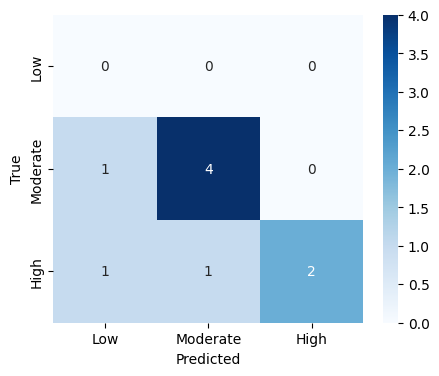

In [ ]:
# === Cell 9: Evaluate the saved best_pipeline, print accuracy, F1, classification report, confusion matrix ===
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# load pipeline if not in memory
try:
    best_pipeline
except NameError:
    if os.path.exists('/content/best_pipeline_with_tuned_fis.joblib'):
        best_pipeline = joblib.load('/content/best_pipeline_with_tuned_fis.joblib')
    else:
        best_pipeline = joblib.load('/content/fallback_pipeline.joblib')

X_full = df_base[features].fillna(df_base[features].median()).values.astype(float)
y_full = df_base['contrib_class'].values.astype(int)

# Evaluate: holdout if enough samples, else CV estimate
if len(y_full) >= 12 and len(np.unique(y_full)) > 1:
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, stratify=y_full, random_state=SEED)
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1w = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f"Holdout Test Accuracy: {acc*100:.2f}%")
    print(f"Holdout Test F1-weighted: {f1w*100:.2f}%")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Low','Moderate','High'], zero_division=0))
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", cm)
    plt.figure(figsize=(5,4)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low','Moderate','High'], yticklabels=['Low','Moderate','High']); plt.xlabel("Predicted"); plt.ylabel("True"); plt.show()
else:
    # dataset small -> do cross-validated estimate (3 folds at most)
    from sklearn.model_selection import cross_val_score
    folds = min(3, max(2, len(y_full)//3))
    scores = cross_val_score(best_pipeline, X_full, y_full, cv=folds, scoring='accuracy')
    print(f"Dataset too small for reliable holdout. CV estimate (n_splits={folds}): mean acc = {scores.mean()*100:.2f}%, std = {scores.std()*100:.2f}%")


Features used (in order): ['meal_freq', 'food_risk', 'water', 'sleep_h', 'stress', 'activity', 'pref_spicy', 'pref_oily', 'pref_fried', 'pref_junk', 'pref_home', 'meal_x_risk', 'stress_x_sleep', 'water_per_meal']
Feature importances (descending):
stress: 0.2113
stress_x_sleep: 0.1908
meal_x_risk: 0.1902
food_risk: 0.1773
activity: 0.0557
pref_fried: 0.0448
water_per_meal: 0.0341
pref_spicy: 0.0189
pref_junk: 0.0189
sleep_h: 0.0179
water: 0.0136
meal_freq: 0.0126
pref_oily: 0.0085
pref_home: 0.0053


/tmp/ipython-input-1389433619.py:26: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, features=X_scaled, feature_names=features, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist

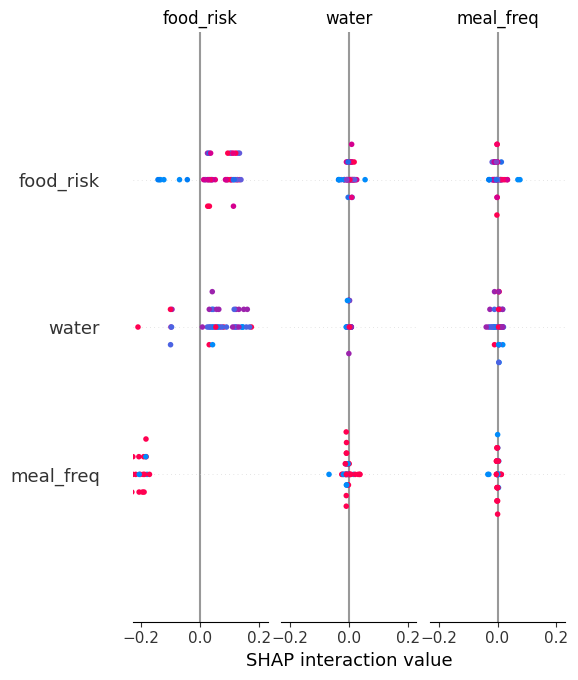

In [ ]:
# === Cell 10: Feature importance & SHAP explanation (best-effort) ===
rf_model = None
# find RF within pipeline
for name, step in best_pipeline.named_steps.items():
    if isinstance(step, RandomForestClassifier):
        rf_model = step
        break

print("Features used (in order):", features)
if rf_model is not None:
    importances = rf_model.feature_importances_
    feat_imp = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
    print("Feature importances (descending):")
    for f, imp in feat_imp:
        print(f"{f}: {imp:.4f}")

    # SHAP (TreeExplainer). Use scaled features as pipeline expects scaled input
    try:
        scaler_step = best_pipeline.named_steps.get('scaler', None)
        imputer_step = best_pipeline.named_steps.get('imputer', None)
        # create scaled matrix
        X_imputed = imputer_step.transform(df_base[features].values)
        X_scaled = scaler_step.transform(X_imputed)
        explainer = shap.TreeExplainer(rf_model)
        shap_values = explainer.shap_values(X_scaled)
        shap.summary_plot(shap_values, features=X_scaled, feature_names=features, show=True)
    except Exception as e:
        print("SHAP failed (likely small data or missing steps). Error:", e)
else:
    print("RandomForest not found in pipeline; skipping feature importances and SHAP.")


In [ ]:
# Cell 11: Save pipeline, tuned FIS params, and provide inference function
joblib.dump(best_pipeline, '/content/final_pipeline.joblib')
joblib.dump(best_params, '/content/tuned_fis_params.joblib')
print("Saved final_pipeline.joblib and tuned_fis_params.joblib to /content")

def predict_user_risk(input_row):
    """
    input_row: dict containing either raw form fields (column names) or numeric mapped keys.
    Returns: dict with fuzzy score+label and ML predicted class + recommendations.
    """
    # map inputs
    meal = input_row.get('meal_freq', None)
    if meal is None and col_map.get('meal_freq') in input_row:
        meal = map_meal_freq(input_row[col_map.get('meal_freq')])
    if meal is None: meal = input_row.get('meal_freq', 3)

    food_risk = input_row.get('food_risk', None)
    if food_risk is None and col_map.get('type_of_food') in input_row:
        food_risk = map_food_risk(input_row.get(col_map.get('type_of_food')), input_row.get(col_map.get('food_pref')))
    if food_risk is None: food_risk = input_row.get('food_risk', 4)

    water = input_row.get('water', None)
    if water is None and col_map.get('water') in input_row:
        water = map_water(input_row[col_map.get('water')])
    if water is None: water = input_row.get('water', 1.5)

    sleep_h = input_row.get('sleep_h', None)
    if sleep_h is None and col_map.get('sleep_h') in input_row:
        sleep_h = map_sleep(input_row[col_map.get('sleep_h')])
    if sleep_h is None: sleep_h = input_row.get('sleep_h', 7)

    stress = input_row.get('stress', None)
    if stress is None and col_map.get('stress') in input_row:
        stress = map_stress(input_row[col_map.get('stress')])
    if stress is None: stress = input_row.get('stress', 5)

    activity = input_row.get('activity', None)
    if activity is None and col_map.get('activity') in input_row:
        activity = map_activity(input_row[col_map.get('activity')])
    if activity is None: activity = input_row.get('activity', 5)

    # compute fuzzy score with tuned sim
    score, label = compute_contribution_using_sim(sim, {
        'meal_freq': meal, 'food_risk': food_risk, 'water': water,
        'sleep_h': sleep_h, 'stress': stress, 'activity': activity
    })

    # engineered features
    row = {}
    row['meal_freq'] = meal; row['food_risk'] = food_risk; row['water'] = water
    row['sleep_h'] = sleep_h; row['stress'] = stress; row['activity'] = activity
    fp_str = input_row.get(col_map.get('food_pref'), '') if col_map.get('food_pref') in input_row else ''
    row['pref_spicy'] = int('spicy' in str(fp_str).lower())
    row['pref_oily']  = int('oily' in str(fp_str).lower())
    row['pref_fried'] = int('fried' in str(fp_str).lower())
    row['pref_junk']  = int('junk' in str(fp_str).lower() or 'fast' in str(fp_str).lower())
    row['pref_home']  = int('home' in str(fp_str).lower())
    row['meal_x_risk'] = row['meal_freq'] * row['food_risk']
    row['stress_x_sleep'] = row['stress'] * (10 - row['sleep_h'])
    row['water_per_meal'] = row['water'] / (row['meal_freq'] + 1e-6)
    row['bmi'] = input_row.get('bmi', np.nan)

    feat_vec = np.array([row[f] if f in row else 0.0 for f in features]).reshape(1,-1)
    pred_cls = best_pipeline.predict(feat_vec)[0]
    pred_proba = best_pipeline.predict_proba(feat_vec)[0].tolist()

    # simple recommendations
    recs = []
    if water < 1.5: recs.append("Increase water intake to 1.5-3 L/day.")
    if sleep_h < 6: recs.append("Improve sleep duration to 6-8 hours.")
    if meal < 2: recs.append("Avoid too few meals; aim for 2-3 meals/day.")
    if food_risk > 6: recs.append("Reduce fried/oily/junk food; prefer high-fiber/home-cooked meals.")

    return {'fuzzy_score':score, 'fuzzy_label':label, 'predicted_class':int(pred_cls), 'class_probs':pred_proba, 'recommendations':recs}

# Demo with first row
demo_input = df_base.iloc[0].to_dict()
print("Demo inference:", predict_user_risk(demo_input))


Saved final_pipeline.joblib and tuned_fis_params.joblib to /content
Demo inference: {'fuzzy_score': 3.667, 'fuzzy_label': 'Moderate', 'predicted_class': 1, 'class_probs': [0.16, 0.81, 0.03], 'recommendations': []}
